# Notebook which explains how the algorithms works and how to interpret the results

## Install all necessary libraries

In [132]:
%pip install dtw-python
%pip install matplotlib
%pip install datetime
%pip install requests
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import all the libraries

In [133]:
import numpy as np
import statistics
from typing import List
import requests as req
from pprint import pprint
import statistics
from dtw import *
import itertools
from datetime import datetime
import matplotlib.pyplot as plt

## Classe qui recupère les données du site Yahoo finance depuis son api ou si les données yahoo ne sont pas accessible, passe par l'api Mboum

In [134]:

class ChartAnalysis():
    def __init__(self):
        self.charts={}
    
    
    def get_chart(self,symbol:str,timeframe:int=30)->list:
        headers = {
            'x-api-key': "mTd2MNVwEe3WFgj5PQ66Tbpq0CyeP8Q7ESjpmYZ2"
        }
        try:
            url = f"https://yfapi.net/v8/finance/chart/{symbol}?range=1mo&region=FR&interval=1d&lang=en"
            response = req.request("GET", url, headers=headers)
            
            
            
            closes = response.json()["chart"]["result"][0]["indicators"]["quote"][0]['close']
            timesamps = response.json()["chart"]["result"][0]["timestamp"]
            

            return [{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, closes)]
        
        except Exception as errorYahoo:
            try:
                headers = {
                'X-Mboum-Secret': "DPEbphxr0mBRzEp956ORDzCn1DFQMX6Xhhf1g5GVw6t6LtJlNmkwmYDGKVed"
                }
                url = f"https://mboum.com/api/v1/hi/history/?symbol={symbol}&interval=1d&diffandsplits=true"
                response = req.request("GET", url, headers=headers).json()


                result = [ {"date":datetime.fromtimestamp(int(value)),"close":response['data']['items'][value]["close"]} for value in response['data']['items']]

                return result[-timeframe:]

            except Exception as errorMboum:
                raise Exception([errorMboum,errorYahoo])
        
    def loading(self,list_actifs:List[str]):
        self.charts = {actif: self.get_chart(actif) for actif in list_actifs}
        
    def resultats_rapports(self,list_actifs:List[str]) -> dict:
        results = {}
        
        
        if self.charts == {}:
            # On construit un dictionnaire avec tous les charts des actifs de la liste
            self.charts = {actif: self.get_chart(actif) for actif in list_actifs}
        
        
        
        # Pour chaque actif 
        for actif_reference,actif_comparaison in itertools.combinations(self.charts, 2):
       
            chart_reference = [value['close'] for value in self.charts[actif_reference]]
            chart_comparison = [value['close'] for value in self.charts[actif_comparaison]]


            results[
                f"distance rapport moyenne {actif_reference} / "
                + actif_comparaison
            ] = self.distance_point_par_point_rapport_moyenne(
                chart_reference,chart_comparison,actif_reference,actif_comparaison
            )
            

            results[
                f"dynamic time warping rapport moyenne {actif_reference} / "
                + actif_comparaison
            ] = self.dynamic_time_warping_par_rapport_moyenne(
                chart_reference,chart_comparison,actif_reference,actif_comparaison
            )
        
        return results                



    
    def distance_point_par_point_rapport_moyenne(self,chart_reference,chart_comparison,actif_reference,actif_comparaison):          
        newreference = []
        newcomparison = []

        for i in range(len(chart_reference)):
            newreference.append(chart_reference[i] / statistics.mean(chart_reference))
            newcomparison.append(chart_comparison[i] / statistics.mean(chart_comparison)) 

        distances = [
            abs(newreference[i] - newcomparison[i])
            for i in range(len(newreference))
        ]
        
        
        for i in range (0,len(newreference)):
            x = [i,i]
            y = [newreference[i],newcomparison[i]]
            plt.plot(x, y,"k--")
        x = np.linspace(0, len(newreference)-1, len(newcomparison))
        
        
        plt.plot(x, newreference, "r", linewidth=4,label=actif_reference)
        plt.plot(x, newcomparison,"b",linewidth=4,label=actif_comparaison)
        plt.legend()
        plt.ylabel("Rapport des prix par rapport à la moyenne sur la periode")

        plt.show()
        
        
        x = np.linspace(0, len(newreference)-1, len(newreference))
        plt.plot(x,distances)
        plt.show()

        return {"distance totale":round(sum(distances),2)}
        
    

    
    def dynamic_time_warping_par_rapport_moyenne(self,chart_reference,chart_comparison,actif_reference,actif_comparaison):
        rearange_reference = []
        rearange_comparison = []

        for value in chart_reference:
            rearange_reference.append(value / statistics.mean(chart_reference))
            
        for value in chart_comparison:
            rearange_comparison.append(value / statistics.mean(chart_comparison))

        # OO method call chain
        warping = dtw(rearange_comparison, rearange_reference, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c"))

        plot = warping.plot(type="twoway")


        return {"distance totale":round(warping.distance,2)}
    
    


## Initializing the class to save the charts (reduce api calls when testing)

In [135]:
chartAnalysis = ChartAnalysis()
assets = ['AAPL','AMZN']
chartAnalysis.loading(assets)


## Doing the analysis for a set of assets

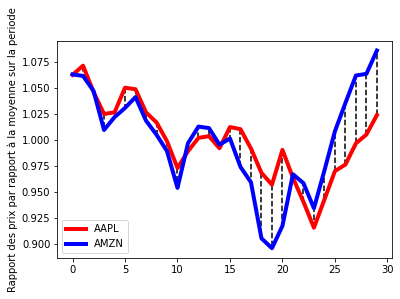

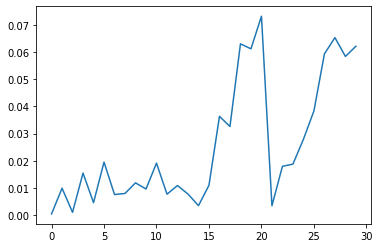

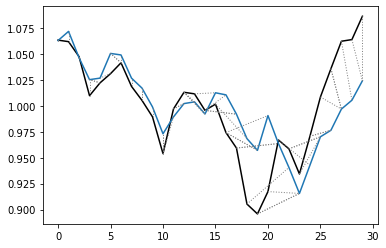

{'distance rapport moyenne AAPL / AMZN': {'distance totale': 0.77},
 'dynamic time warping rapport moyenne AAPL / AMZN': {'distance totale': 0.52}}


In [136]:


pprint(chartAnalysis.resultats_rapports(assets))

> On remarque que la distance recuperée avec le dynamic time warping est inférieure à celle de la distance point par point ce qui est logique puisque l'alignement est adaptée.